In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from typing import Tuple, Dict
from sklearn.manifold import TSNE
import umap
import phate
import tphate
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
import warnings
from scipy.stats import pearsonr
from plotnine import *

C:\Users\ahuja\anaconda3\envs\TDR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# tells us : Are Face and Car represented similarly or differently at the same time?
# 32 channels:  32 dimensions are reduced to 2 dimensions
# Channel data is collapsed

# SS avg trials

Calculating PHATE...
  Running PHATE on 60 observations and 32 variables.
  Calculating graph and diffusion operator...


C:\Users\ahuja\anaconda3\envs\TDR\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -6.8% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.06 seconds.
Calculated PHATE in 0.12 seconds.
Calculating TPHATE...
  Running TPHATE on 60 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Learning the autocorrelation function...
  Calculating Autocorr kernel...
    Dropoff point: 8
  Combining PHATE operator and autocorr operator
  Calculating diffusion potential...
  Calculating metric MDS...
Calculate

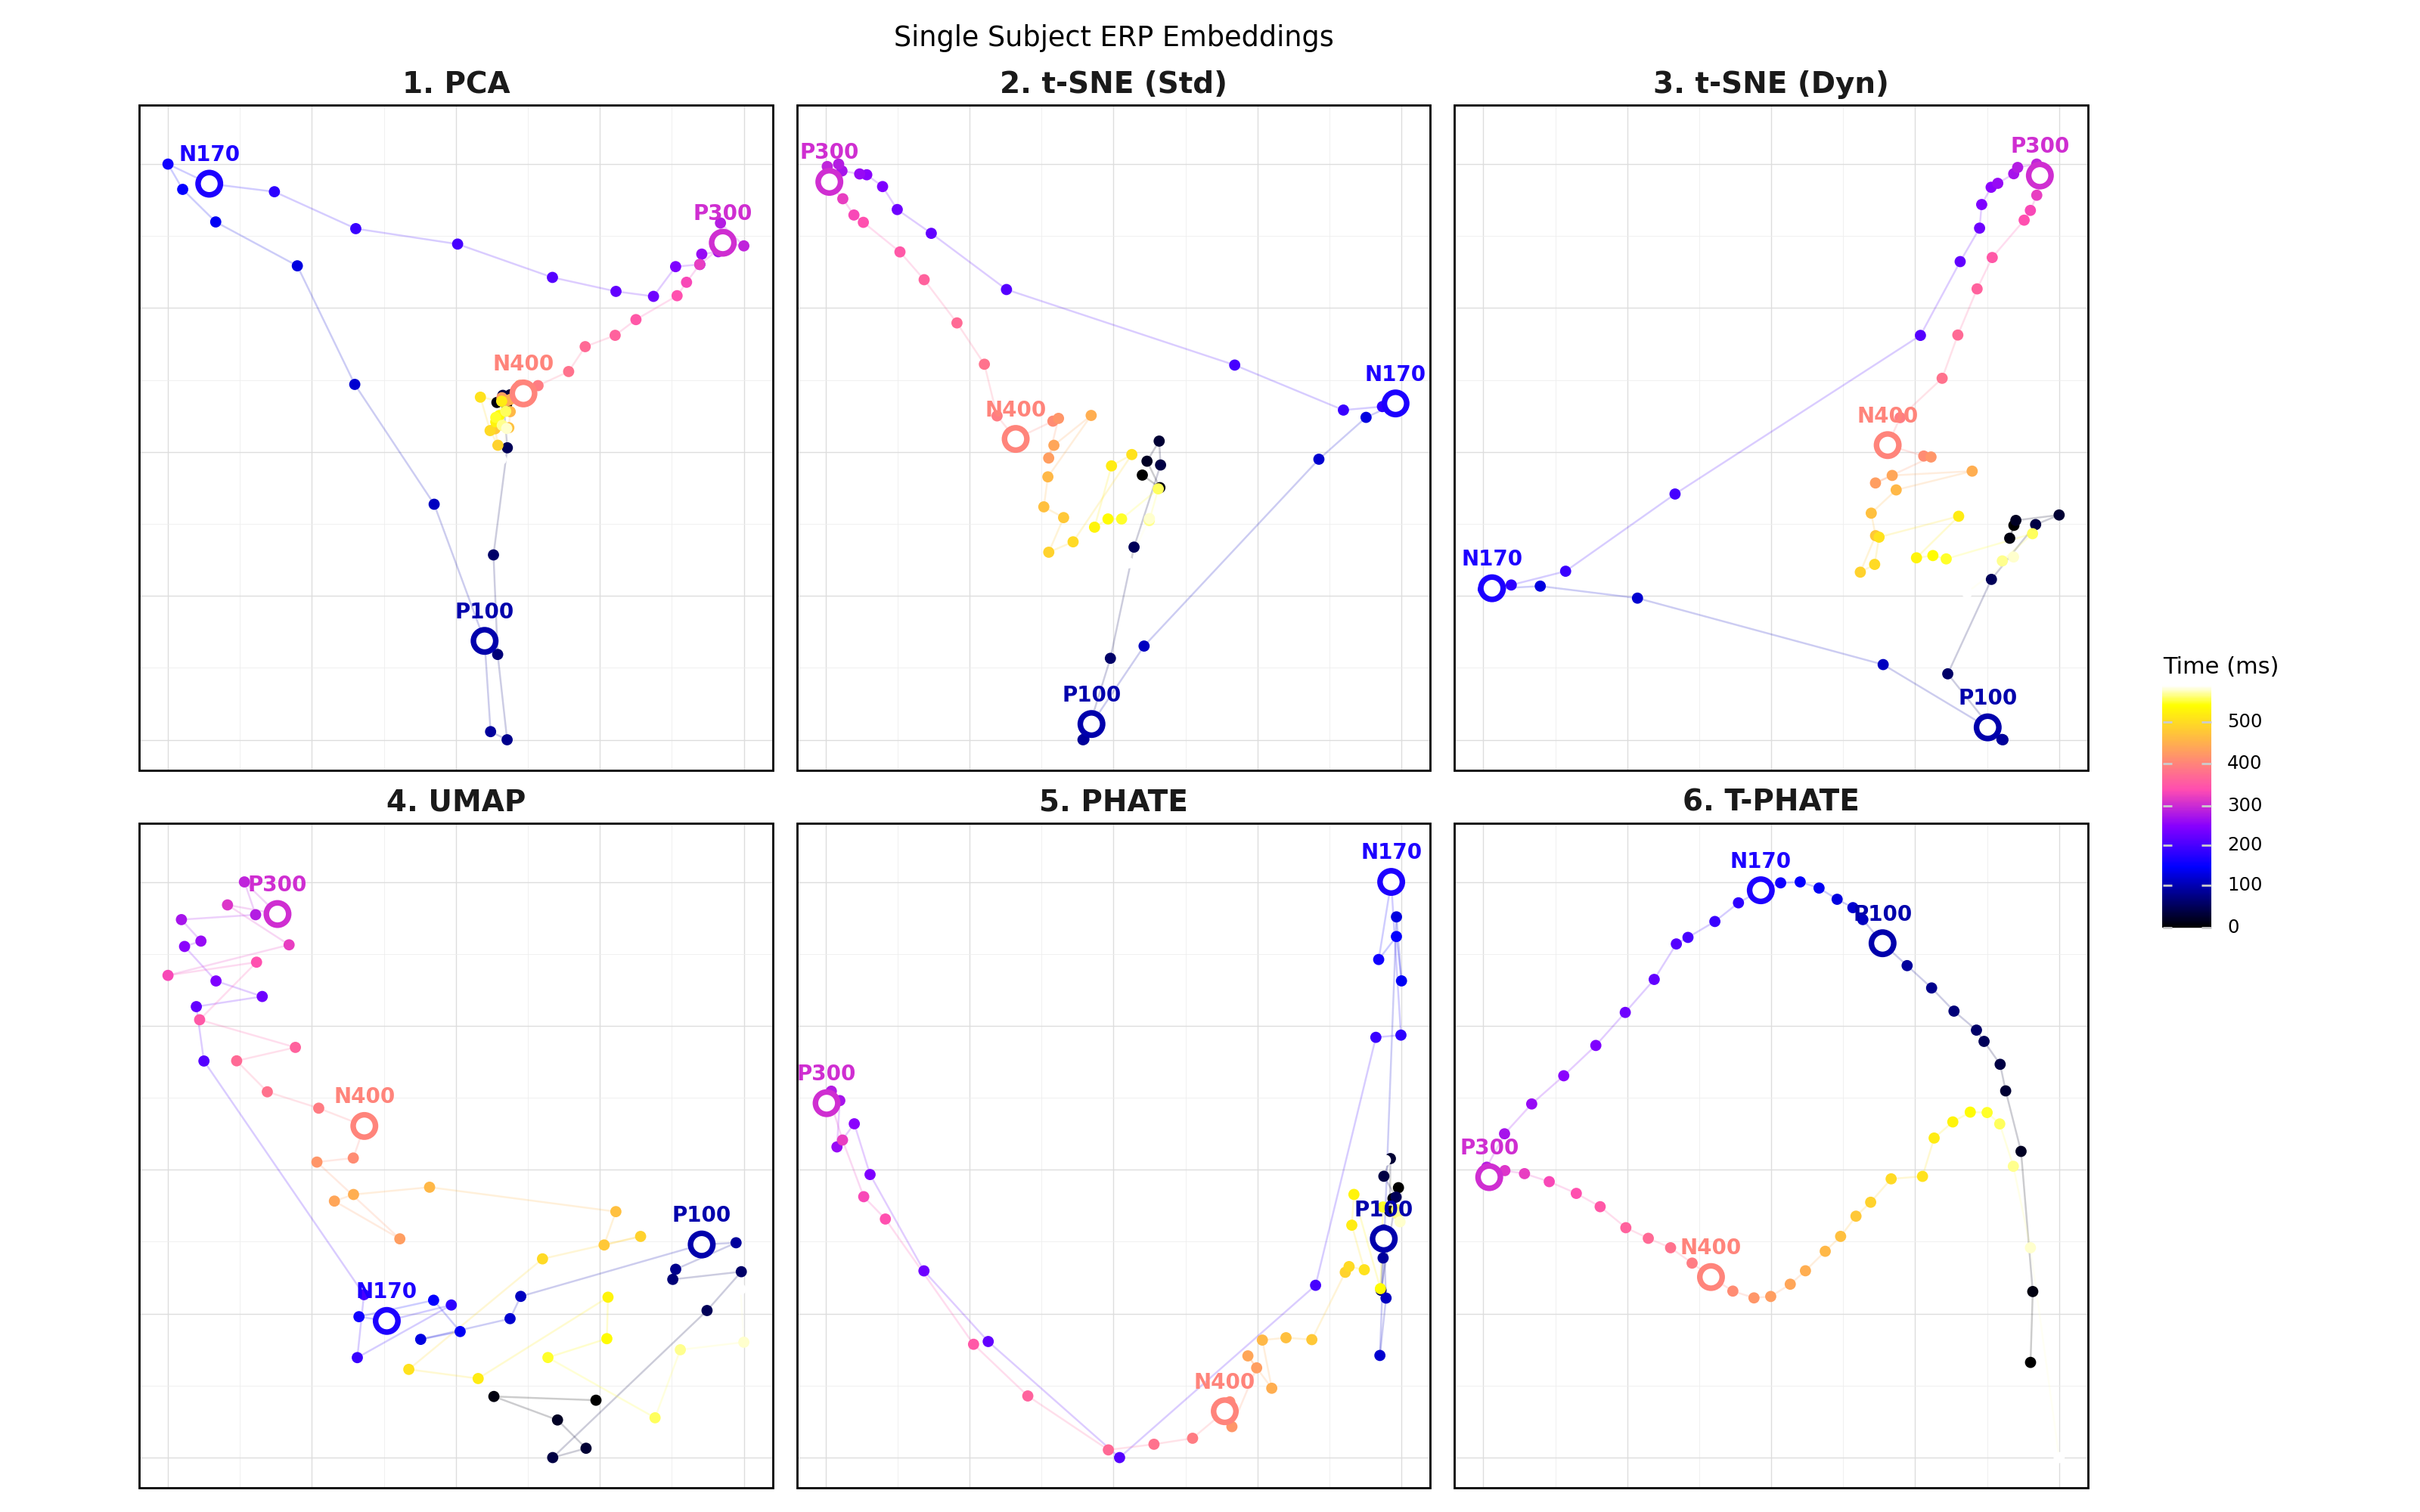

In [ ]:
# SS avg trials
# Load and Compute
df = pd.read_csv("SS_ALL_ERP_4components_32ch_noise8.csv")
X_raw = df.drop(columns=['Time_ms']).values

results = {
    '1. PCA': PCA(n_components=2).fit_transform(X_raw),
    '2. t-SNE (Std)': TSNE(init='random', random_state=42).fit_transform(X_raw),
    '3. t-SNE (Dyn)': TSNE(init='pca', learning_rate='auto', random_state=42).fit_transform(X_raw),
    '4. UMAP': umap.UMAP(random_state=42).fit_transform(X_raw),
    '5. PHATE': phate.PHATE(knn=10, random_state=42, n_jobs=-1).fit_transform(X_raw),
    '6. T-PHATE': tphate.TPHATE(knn=10, t=4, random_state=42, n_jobs=-1).fit_transform(X_raw),
}
all_dfs = []
scaler = MinMaxScaler()
for method, emb in results.items():
    temp = pd.DataFrame(scaler.fit_transform(emb), columns=['X', 'Y'])
    temp['Time_ms'], temp['Method'] = df['Time_ms'], method
    all_dfs.append(temp)
df_all = pd.concat(all_dfs, ignore_index=True)
peak_map = {100: 'P100', 170: 'N170', 300: 'P300', 400: 'N400'}
peaks_points = df_all[df_all['Time_ms'].isin(peak_map.keys())].copy()
# Ensure exactly one label per Method per Timepoint
peaks_labels = peaks_points.groupby(['Method', 'Time_ms']).first().reset_index()
peaks_labels['PeakLabel'] = peaks_labels['Time_ms'].map(peak_map)
colors = [plt.cm.gnuplot2(i) for i in np.linspace(0, 1, 256)]
embedding_plot = (
    ggplot(df_all, aes(x='X', y='Y', color='Time_ms'))
    + geom_path(aes(group=1), alpha=0.2, size=0.5)
    + geom_point(alpha=1, size=2)
    + geom_point(data=peaks_points, mapping=aes(x='X', y='Y', color='Time_ms'),
                 shape='o', size=4.5, fill='white', stroke=1.5)
    + geom_text(data=peaks_labels, mapping=aes(label='PeakLabel'), size=10,
                fontweight='bold', nudge_y=0.05)
    + facet_wrap('~Method', ncol=3)
    + scale_color_gradientn(colors=colors)
    + coord_fixed(ratio=1)
    + theme_minimal()
    + theme(
        figure_size=(16, 10),
        panel_grid_major=element_line(color='#dddddd', size=0.5),
        panel_grid_minor=element_line(color='#eeeeee', size=0.3),
        axis_text=element_blank(),
        axis_title=element_blank(),
        panel_border=element_rect(color='black', fill=None),
        strip_text=element_text(size=14, weight='bold'),
        legend_position='right'
    )
    + labs(title='Single Subject ERP Embeddings', color='Time (ms)')
)
embedding_plot

# SS avg trials per condition

C:\Users\ahuja\anaconda3\envs\TDR\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


Calculating PHATE...
  Running PHATE on 120 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -2.9% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.18 seconds.
Calculated PHATE in 0.29 seconds.
Calculating TPHATE...
  Running TPHATE on 120 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.05 seconds.
  Learning t

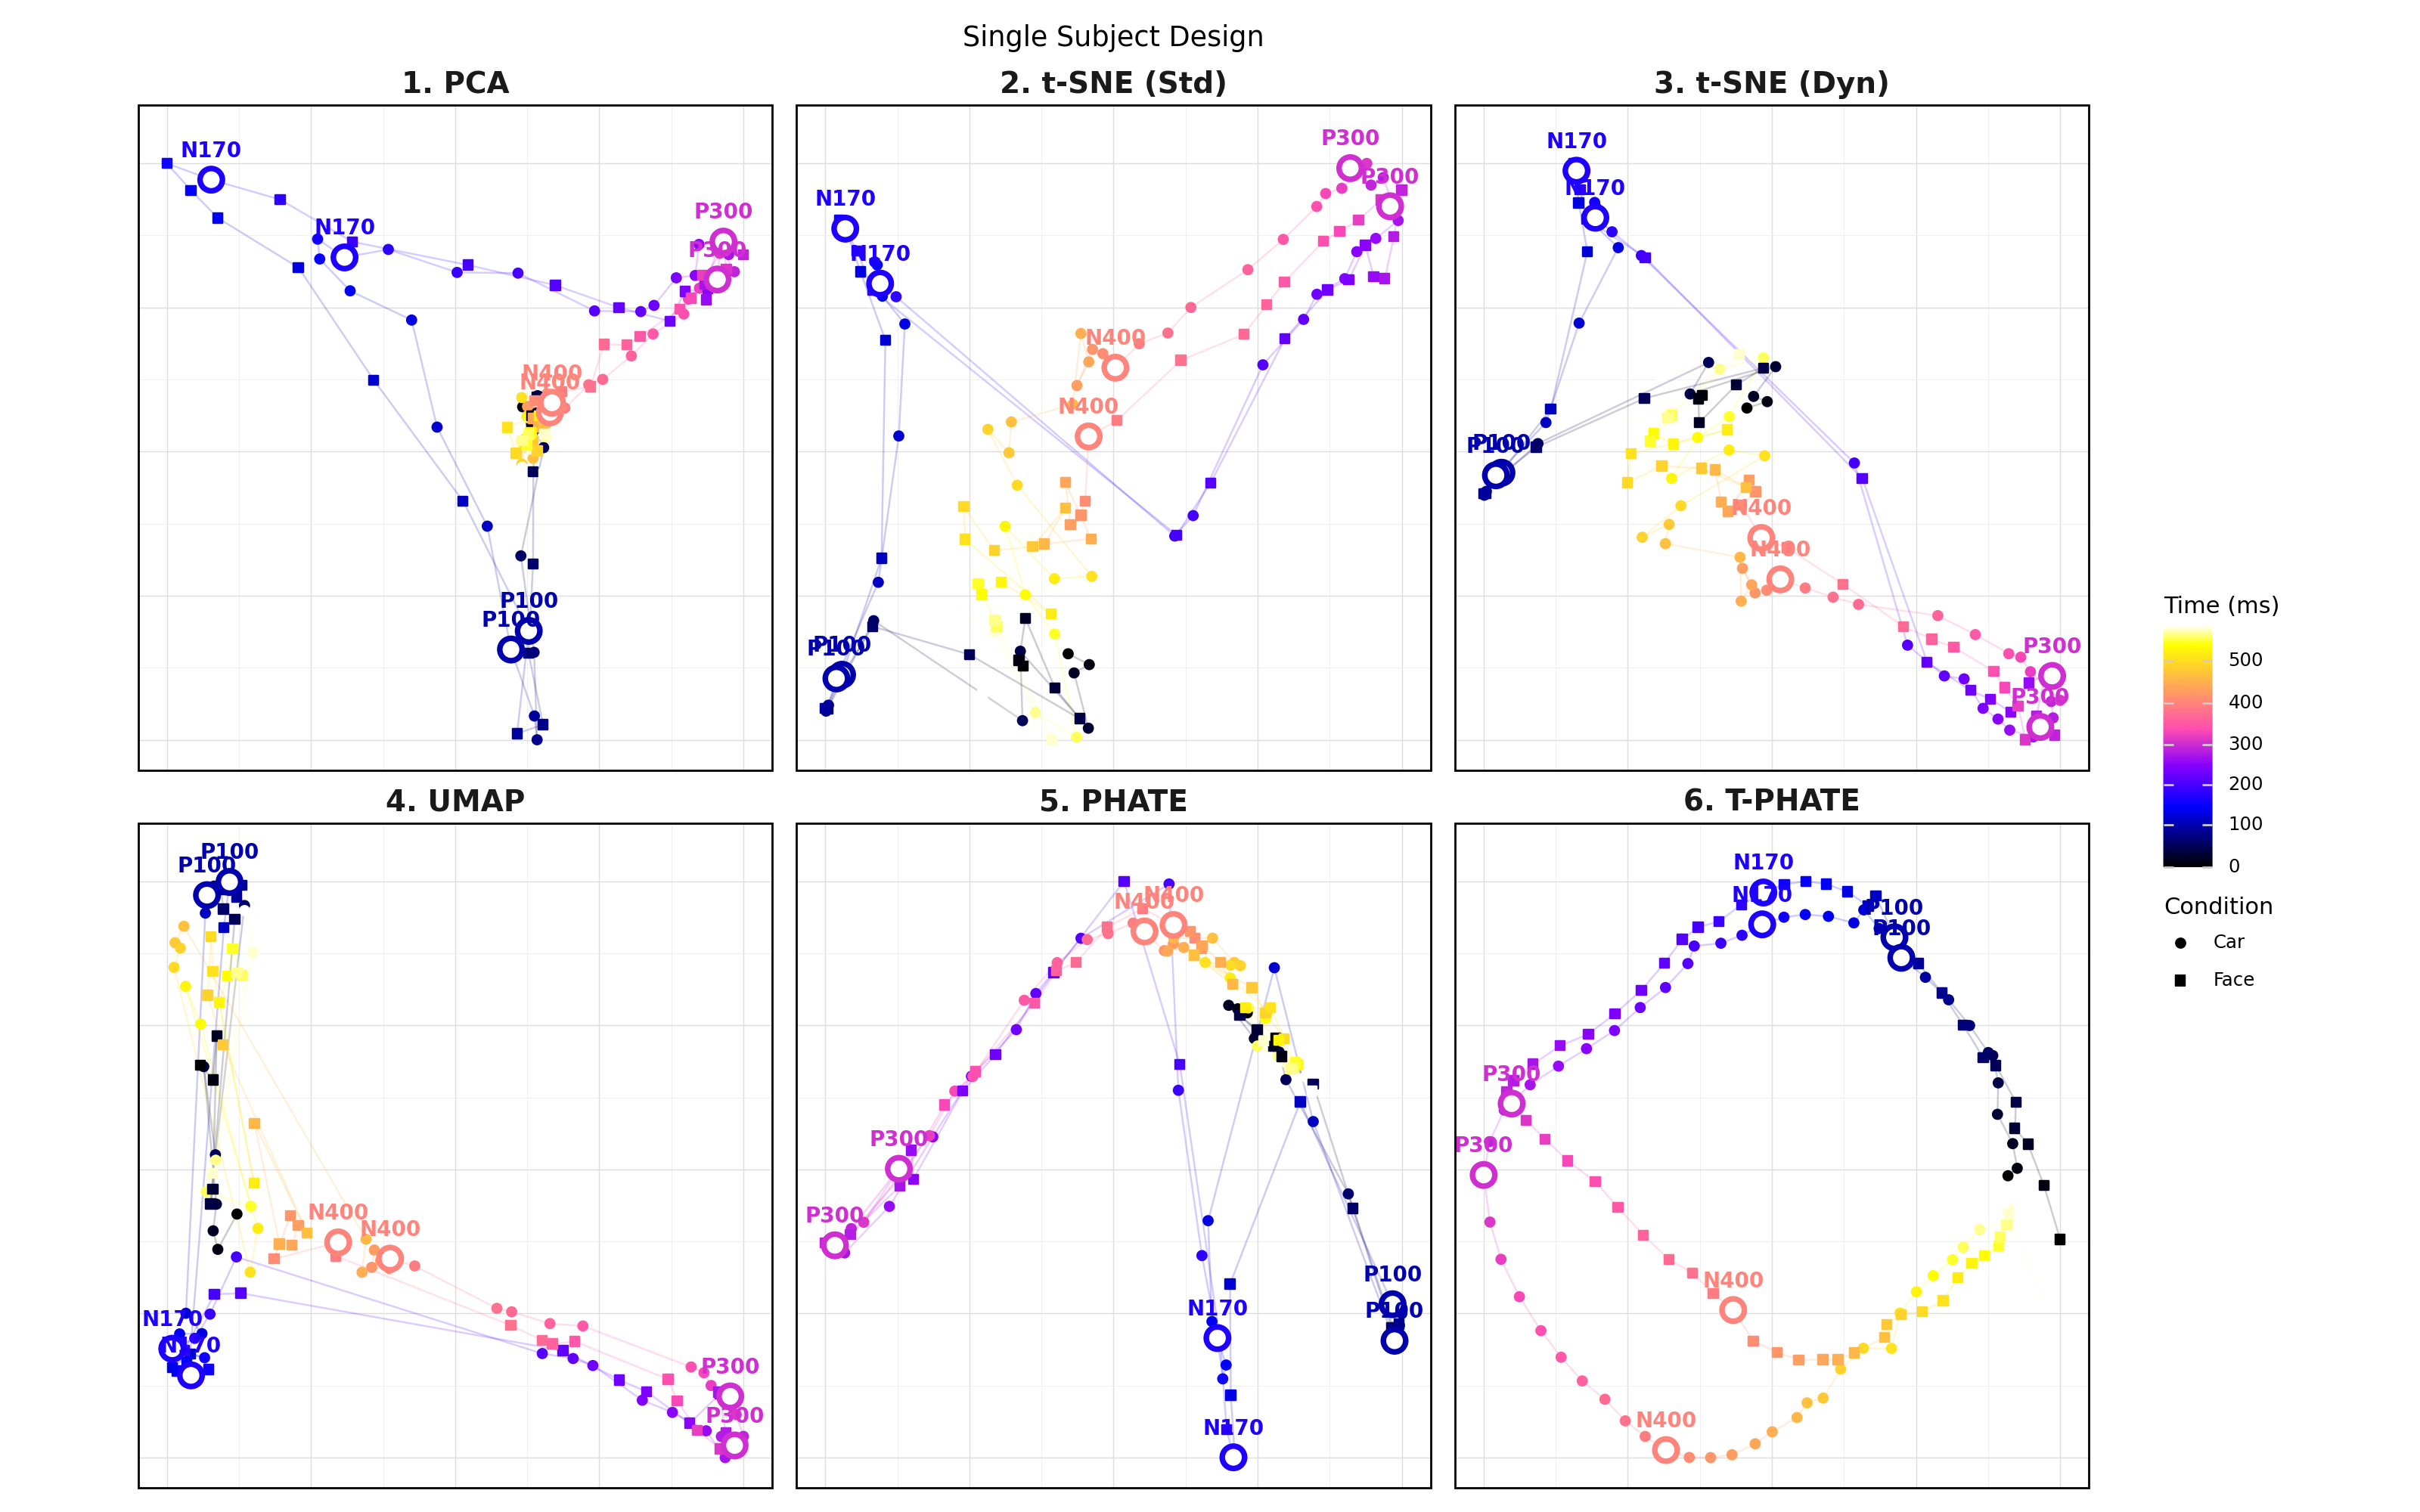

In [ ]:
#Load Data
df = pd.read_csv("SS_ALL_Face_vs_Car_4components_32ch_noise8.csv")
metadata_cols = ["Time_ms", "Condition"]
X_raw = df.drop(columns=metadata_cols).values

results = {
    "1. PCA": PCA(n_components=2).fit_transform(X_raw),
    "2. t-SNE (Std)": TSNE(init="random", random_state=42).fit_transform(X_raw),
    #"3. t-SNE (Dyn)": TSNE(init="pca", learning_rate="auto", random_state=42).fit_transform(X_raw), #change to time preserving
    "4. UMAP": umap.UMAP(random_state=42).fit_transform(X_raw),
    "5. PHATE": phate.PHATE(knn=10, random_state=42, n_jobs=-1).fit_transform(X_raw),
    "6. T-PHATE": tphate.TPHATE(knn=10, t=4, random_state=42, n_jobs=-1).fit_transform(X_raw)
}

all_dfs = []
scaler = MinMaxScaler()
for method, emb in results.items():
    temp = pd.DataFrame(scaler.fit_transform(emb), columns=["X", "Y"])
    temp["Time_ms"], temp["Condition"], temp["Method"] = df["Time_ms"], df["Condition"], method
    all_dfs.append(temp)
df_all = pd.concat(all_dfs, ignore_index=True)

peak_map = {100: "P100", 170: "N170", 300: "P300", 400: "N400"}
peaks_points = df_all[df_all["Time_ms"].isin(peak_map.keys())].copy()
peaks_labels = peaks_points.groupby(["Method", "Condition", "Time_ms"]).first().reset_index()
peaks_labels["PeakLabel"] = peaks_labels["Time_ms"].map(peak_map)

#Visualization
colors = [plt.cm.gnuplot2(i) for i in np.linspace(0, 1, 256)]
comparison_plot_condition_SS = (
    ggplot(df_all, aes(x="X", y="Y", color="Time_ms", shape="Condition"))
    + geom_path(aes(group="Condition"), alpha=0.2, size=0.5)
    + geom_point(alpha=1, size=2)
    + geom_point(peaks_points, aes(x="X", y="Y", color="Time_ms"), shape="o", size=4.5, fill="white", stroke=1.5)
    + geom_text(peaks_labels, aes(label="PeakLabel"), size=10, fontweight="bold", nudge_y=0.05)
    + facet_wrap("~Method", ncol=3)
    + scale_color_gradientn(colors=colors)
    + scale_shape_manual(values=["o", "s"])
    + coord_fixed(ratio=1)
    + theme_minimal()
    + theme(figure_size=(16, 10), panel_grid_major=element_line(color="#dddddd", size=0.5), 
            panel_grid_minor=element_line(color="#eeeeee", size=0.3), axis_text=element_blank(), 
            axis_title=element_blank(), panel_border=element_rect(color="black", fill=None), 
            strip_text=element_text(size=14, weight="bold"), legend_position="right")
    + labs(title="Single Subject Design", color="Time (ms)", shape="Condition")
)
comparison_plot_condition_SS

# MS avg all trials per condition

C:\Users\ahuja\anaconda3\envs\TDR\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


Calculating PHATE...
  Running PHATE on 1200 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 0.22 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 1.19 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -1.8% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 2.79 seconds.
Calculated PHATE in 4.49 seconds.
Calculating TPHATE...
  Running TPHATE on 1200 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
    Calculated affi

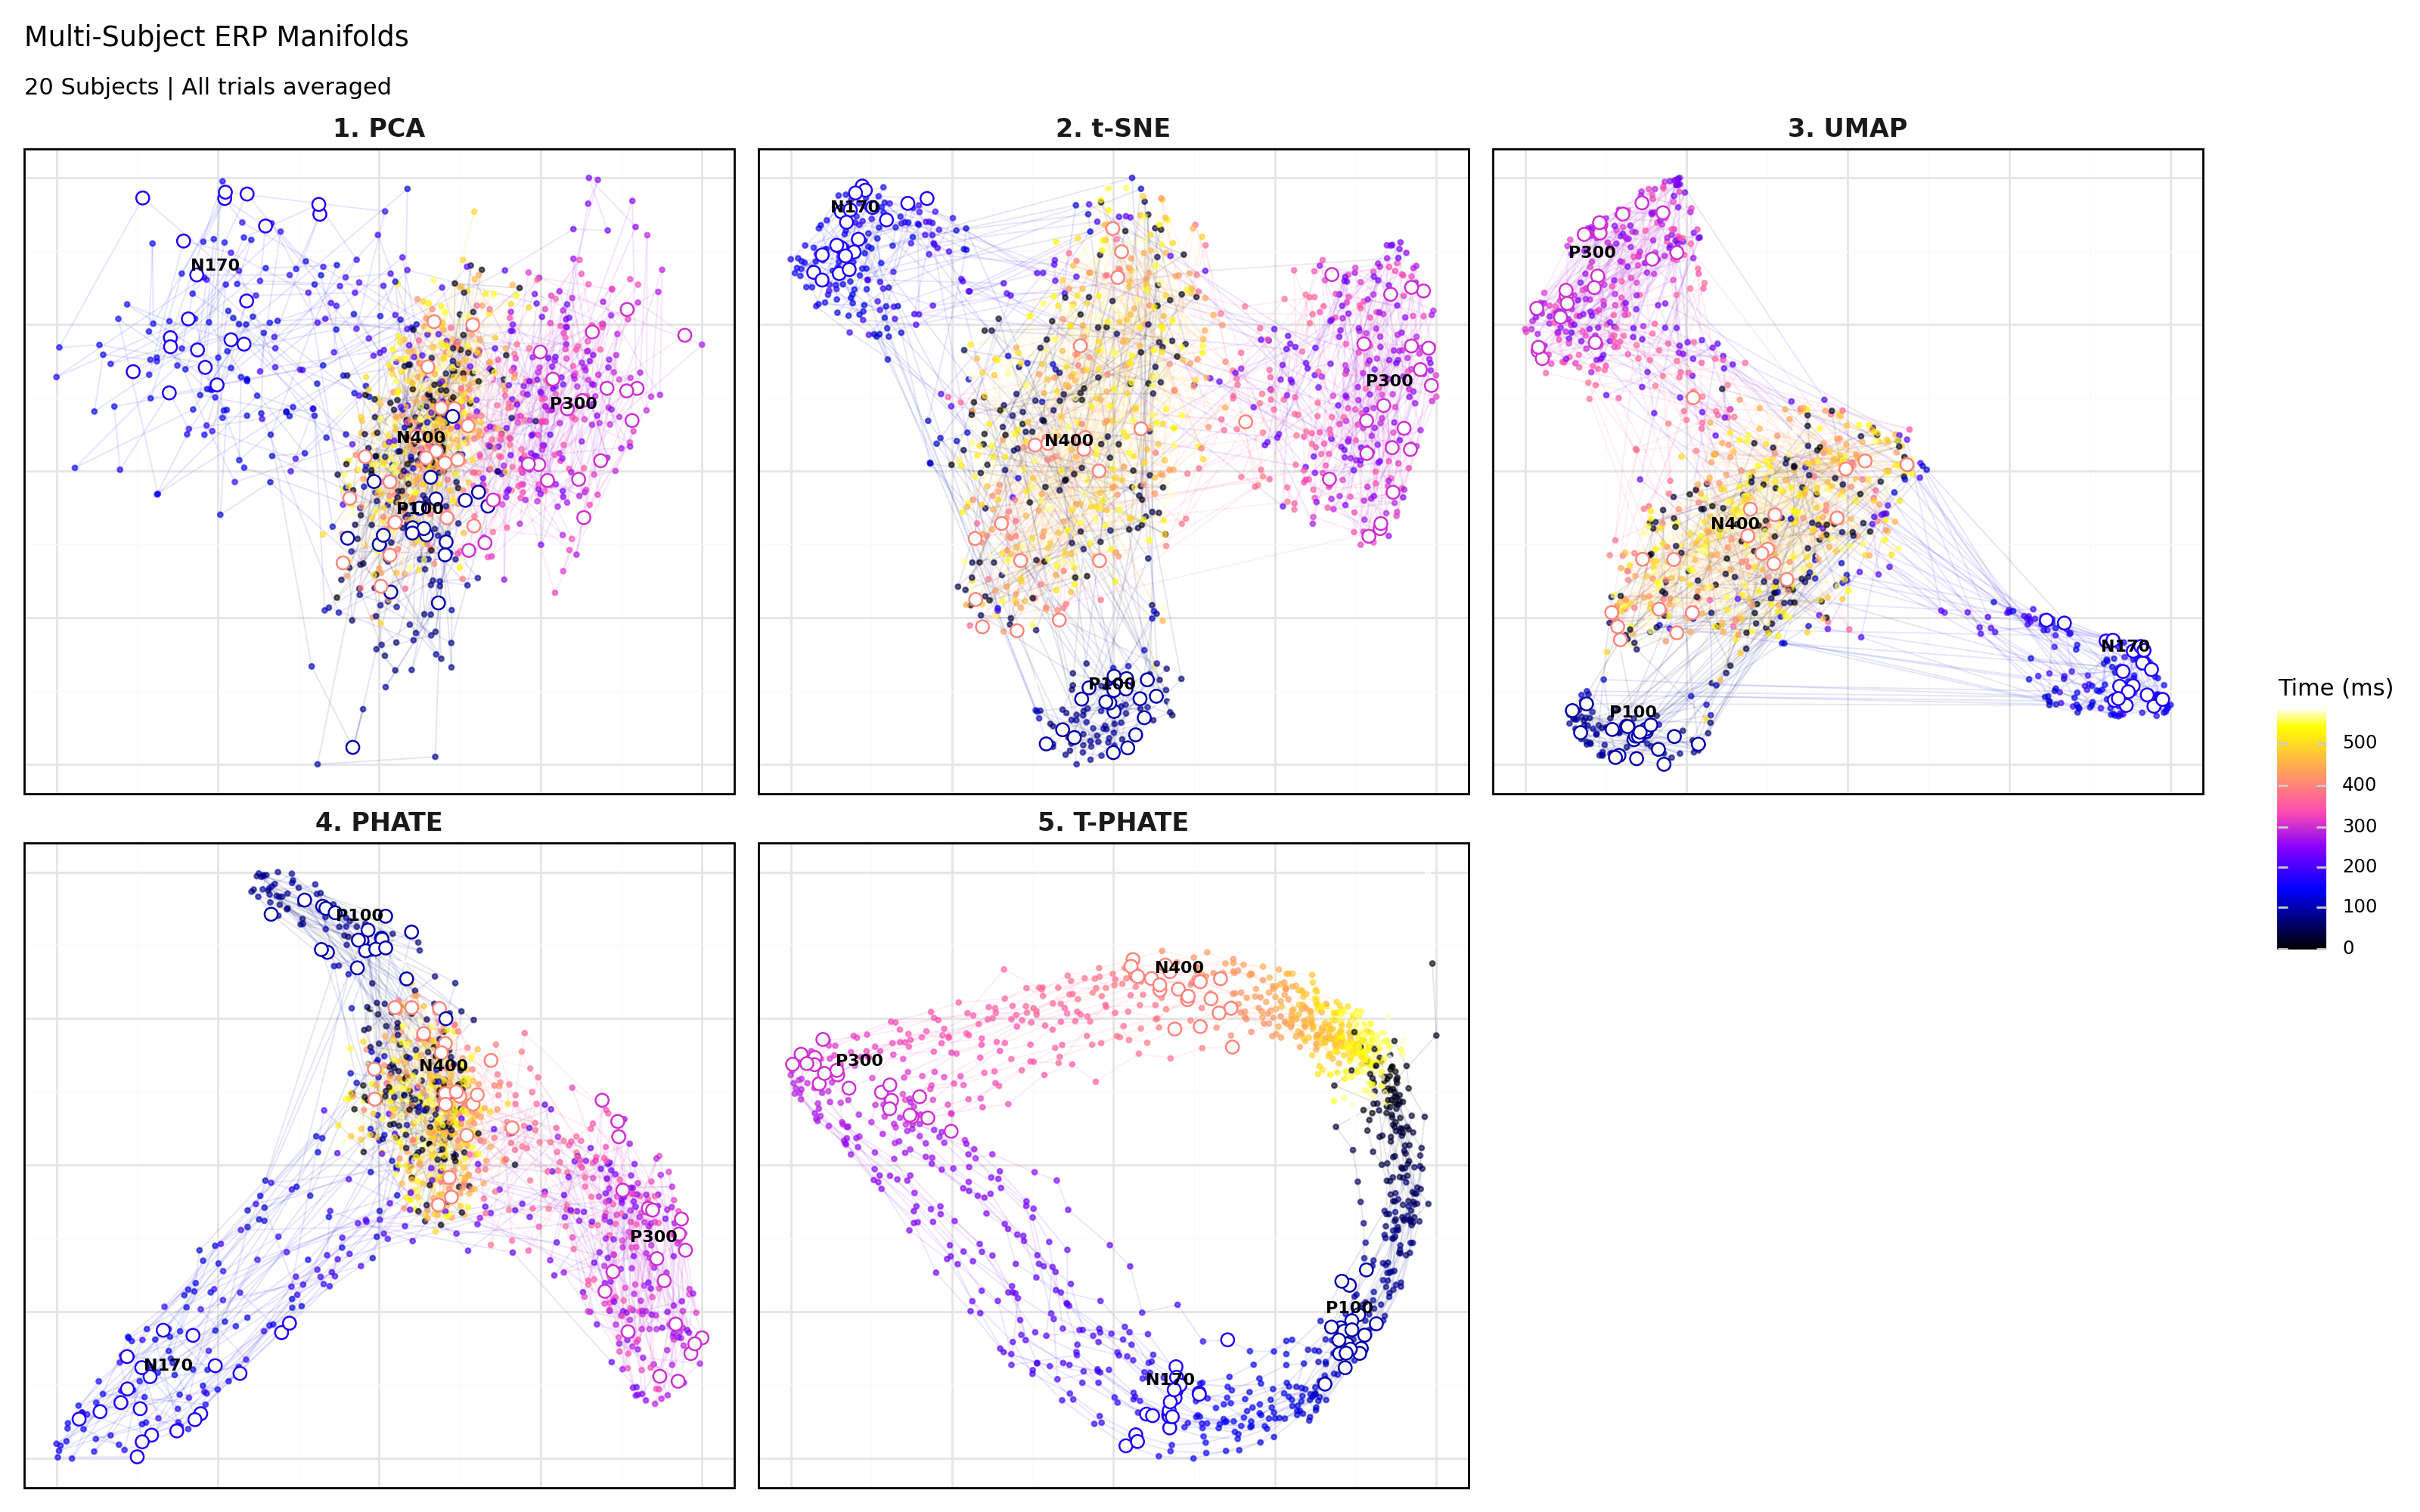

In [ ]:
# Load data
df = pd.read_csv("26jan_MS_20Sub_AvgAllTrials.csv")
metadata_cols = ['Time_ms', 'SubjectID']
X_raw = df.drop(columns=metadata_cols).values

results = {
    '1. PCA': PCA(n_components=2).fit_transform(X_raw),
    '2. t-SNE': TSNE(init='pca', random_state=42, perplexity=30).fit_transform(X_raw),
    '3. UMAP': umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_raw),
    '4. PHATE': phate.PHATE(knn=15, t='auto', random_state=42, n_jobs=-1).fit_transform(X_raw),
    '5. T-PHATE': tphate.TPHATE(knn=15, t=4, random_state=42, n_jobs=-1).fit_transform(X_raw),
}

all_dfs = []
scaler = MinMaxScaler()
for method, emb in results.items():
    temp = pd.DataFrame(scaler.fit_transform(emb), columns=['X', 'Y'])
    temp['Time_ms'], temp['SubjectID'], temp['Method'] = df['Time_ms'], df['SubjectID'], method
    all_dfs.append(temp)
df_all = pd.concat(all_dfs, ignore_index=True)

# Concise Peak Handling (Collapsed to one label per method facet)
peak_map = {100.0: 'P100', 170.0: 'N170', 300.0: 'P300', 400.0: 'N400'}
peaks_points = df_all[df_all['Time_ms'].isin(peak_map.keys())].copy()
peaks_labels = peaks_points.groupby(['Method', 'Time_ms']).agg({'X':'mean', 'Y':'mean'}).reset_index()
peaks_labels['PeakLabel'] = peaks_labels['Time_ms'].map(peak_map)

#  Visualization
colors = [plt.cm.gnuplot2(i) for i in np.linspace(0, 1, 256)]
embedding_plot_MS = (
    ggplot(df_all, aes(x='X', y='Y', color='Time_ms'))
    + geom_path(aes(group='SubjectID'), alpha=0.1, size=0.4)
    + geom_point(alpha=0.6, size=0.8)
    + geom_point(peaks_points, shape='o', size=3, fill='white', stroke=0.5)
    + geom_text(peaks_labels, aes(label='PeakLabel'), size=8, fontweight='bold', color='black', nudge_y=0.04)
    + facet_wrap('~Method', ncol=3)
    + scale_color_gradientn(colors=colors)
    + theme_minimal()
    + theme(figure_size=(16, 10), axis_text=element_blank(), axis_title=element_blank(), 
            panel_border=element_rect(color='black', fill=None), 
            strip_text=element_text(size=12, weight='bold'), legend_position='right')
    + labs(title='Multi-Subject ERP Manifolds', subtitle='20 Subjects | All trials averaged', color='Time (ms)')
)
embedding_plot_MS

# MS 4 subjects avg all trials per condition

Computing Manifolds for 480 points...


C:\Users\ahuja\anaconda3\envs\TDR\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


Calculating PHATE...
  Running PHATE on 480 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.14 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.04 seconds.
Calculated PHATE in 2.32 seconds.
Calculating TPHATE...
  Running TPHATE on 480 observations and 32 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.07 seconds.
  Learning the autocorrelation function...
  Calculating Autocorr kernel...
    Dropoff point: 10


C:\Users\ahuja\AppData\Local\Temp\ipykernel_35956\360227099.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


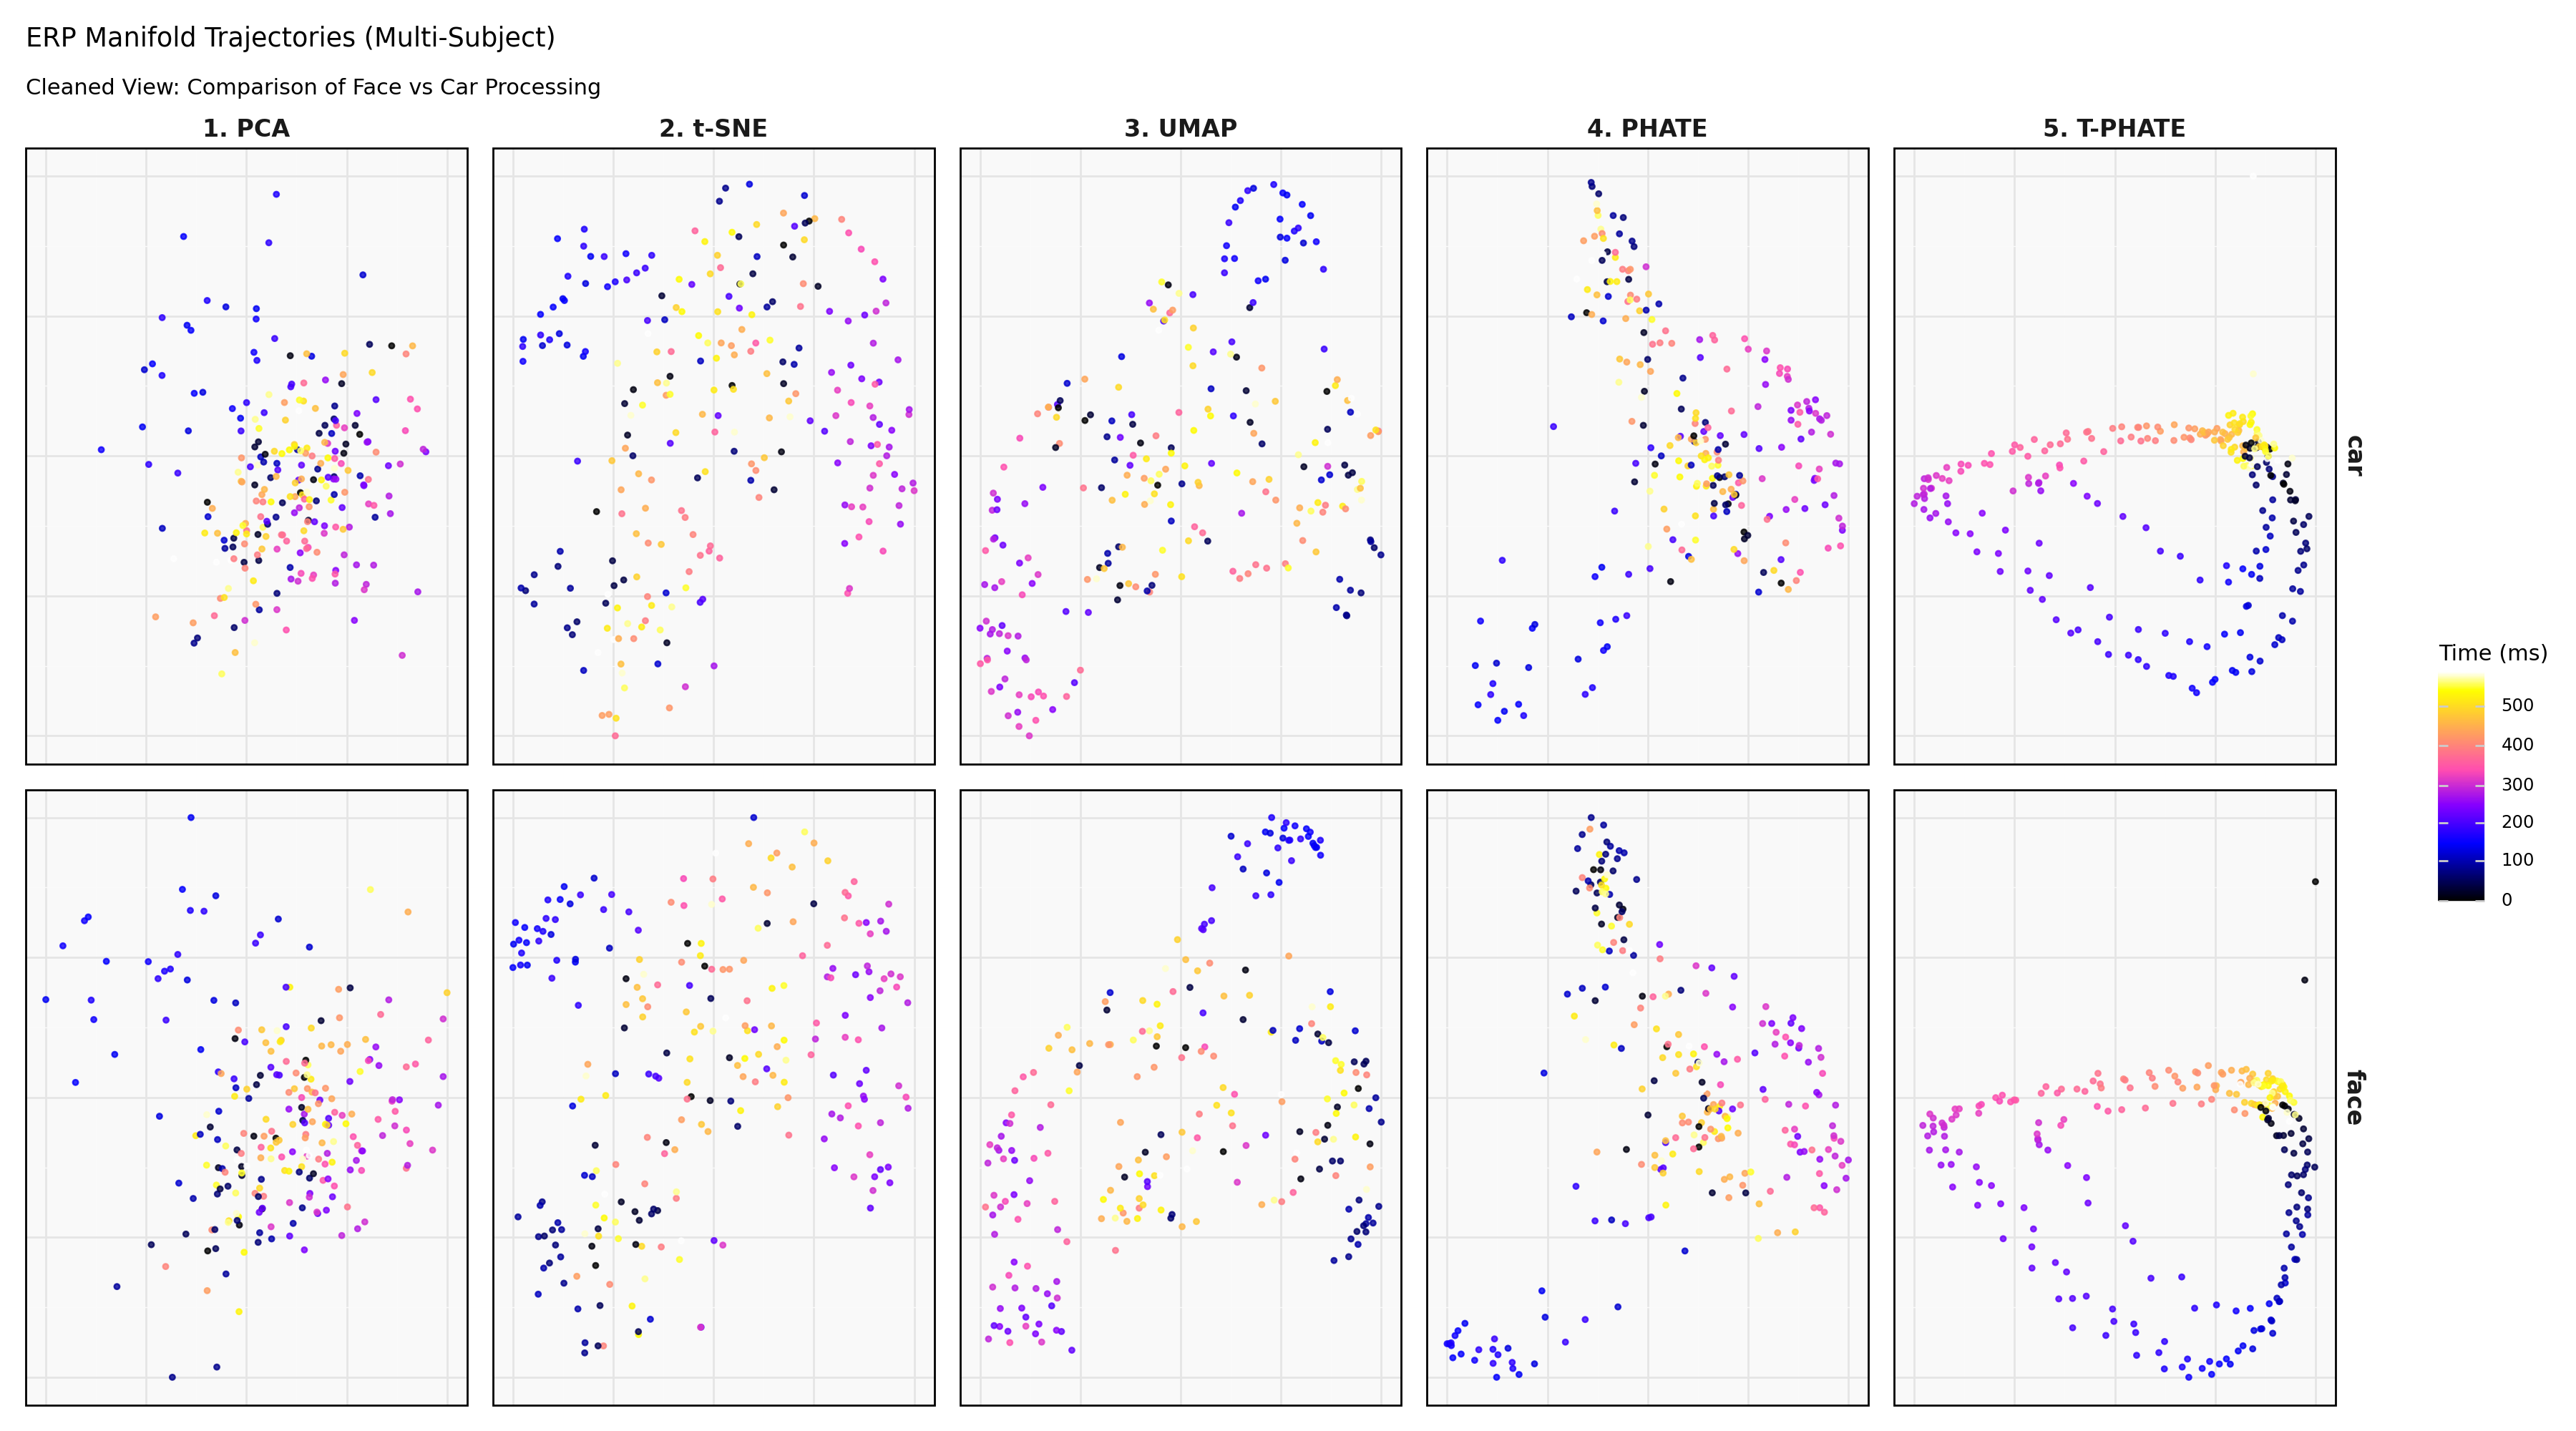

In [ ]:
# Load Data
df = pd.read_csv("MS_4Sub_AvgCondition.csv")   #26jan_MS_4Sub_AvgCondition.csv
df['SubjectID'] = df['SubjectID'].astype(str)
df['Condition'] = df['Condition'].astype(str)
metadata_cols = ['Time_ms', 'Condition', 'SubjectID']
channel_cols = [c for c in df.columns if c not in metadata_cols]
X_raw = df[channel_cols].values

print(f"Computing Manifolds for {X_raw.shape[0]} points...")
results = {
    '1. PCA': PCA(n_components=2).fit_transform(X_raw),
    '2. t-SNE': TSNE(n_components=2, init='pca', random_state=42, perplexity=30).fit_transform(X_raw),
    '3. UMAP': umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_raw),
    '4. PHATE': phate.PHATE(knn=15, t='auto', random_state=42, n_jobs=-1).fit_transform(X_raw),
    '5. T-PHATE': tphate.TPHATE(knn=15, t=4, random_state=42, n_jobs=-1).fit_transform(X_raw),
}
scaler = MinMaxScaler()
all_dfs = []

for method, emb in results.items():
    temp = df[metadata_cols].copy()
    scaled = scaler.fit_transform(emb)
    temp['X'], temp['Y'] = scaled[:, 0], scaled[:, 1]
    temp['Method'] = method
    all_dfs.append(temp)

df_all = pd.concat(all_dfs)
cmap_gnu = cm.get_cmap('gnuplot2')
gnu_hex = [rgb2hex(cmap_gnu(i)) for i in np.linspace(0, 1, 256)]

# Plotting
comparison_plot_condition_MS = (
    ggplot(df_all, aes(x='X', y='Y', color='Time_ms'))
    # Path shows each subject's brain state over time
    #+ geom_path(aes(group='SubjectID'), alpha=0.15, size=0.5)
    + geom_point(alpha=0.8, size=1)
    + facet_grid('Condition ~ Method')
    + scale_color_gradientn(colors=gnu_hex)
    + theme_minimal()
    + theme(
        figure_size=(18, 10),
        panel_background=element_rect(fill='#f9f9f9'),
        axis_text=element_blank(),
        axis_title=element_blank(),
        panel_border=element_rect(color='black', fill=None),
        strip_text=element_text(size=12, weight='bold'),
        legend_position='right'
    )
    + labs(
        title='ERP Manifold Trajectories (Multi-Subject)',
        subtitle='Cleaned View: Comparison of Face vs Car Processing',
        color='Time (ms)'
    )
)
comparison_plot_condition_MS